In [2]:
from tiffConverter import convert_to_numpy
import tomopy

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
def cropAndAlign(kevinProj, tomopyProj):
    #Crop to correct region like tomo projection
    w, h = tomopyProj.shape
    res = cv2.matchTemplate(kevinProj.astype(np.float32),tomopyProj.astype(np.float32),cv2.TM_CCOEFF_NORMED)
    loc = np.where( res == res.max())
    print(loc)
    pt = list(zip(*loc[::-1]))[0]
    print(pt)
    kevinProj = kevinProj[pt[1]:w + pt[1] , pt[0]: h+pt[0] ]

    return kevinProj, tomopyProj

def showHistogramComparison(kevinProj, tomopyProj_scaled):

    plotHeight = 7500
    plotwidth = 0.15

    # Define a common bin range and bin count
    common_range = (min(tomopyProj_scaled.min(), kevinProj.min()), max(tomopyProj_scaled.max(), kevinProj.max()))
    bin_count = 100
    
    # Compute histograms with the same bins
    hist1, bin_edges = np.histogram(tomopyProj_scaled, bins=bin_count, range=common_range)
    hist2, bin_edges = np.histogram(kevinProj, bins=bin_count, range=common_range)
    
    # Subtract the histograms
    hist_diff = hist2 - hist1

    # Plot the difference histogram
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    #Plotting
    fig1, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,12))
    axs[0,0].imshow(tomopyProj_scaled)
    axs[0,0].set_title('Tomopy Projection')
    axs[1,0].hist(np.ndarray.flatten(tomopyProj_scaled), bins=bin_edges, alpha=0.5, color = 'blue')
    axs[1,0].set_title('Histogram of Tomopy Projection')
    axs[1,0].set_ylim(0,plotHeight)
    axs[1,0].set_xlim(-plotwidth,plotwidth)
    
    axs[0,1].imshow(kevinProj)
    axs[0,1].set_title('Kevin Projection')
    axs[1,1].hist(np.ndarray.flatten(kevinProj), bins=bin_edges, alpha=0.5, color = 'red')
    axs[1,1].set_title('Histogram of Kevin Projection')
    axs[1,1].set_ylim(0,plotHeight)
    axs[1,1].set_xlim(-plotwidth,plotwidth)
    
    axs[2,0].hist(np.ndarray.flatten(tomopyProj_scaled), bins=bin_edges, alpha=0.5, color = 'blue')
    axs[2,0].hist(np.ndarray.flatten(kevinProj), bins=bin_edges, alpha=0.5, color = 'red')
    axs[2,0].set_ylim(0,plotHeight)
    axs[2,0].set_xlim(-plotwidth,plotwidth)
    axs[2,0].set_title('Both histograms on top of eachother')
    
    
    # axs[2,1].plot(bin_centers, hist_diff, label='Difference (Hist1 - Hist2)', color='green', drawstyle='steps-mid')
    axs[2,1].bar(bin_centers, hist_diff, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='Difference (Hist1 - Hist2)', color='red')
    axs[2,1].legend()
    axs[2,1].set_title('Difference of Histograms (Hist1 - Hist2)')
    axs[2,1].set_ylim(-plotHeight//2,plotHeight//2)
    axs[2,1].set_xlim(-plotwidth,plotwidth)
    
    plt.show()

400 630 630


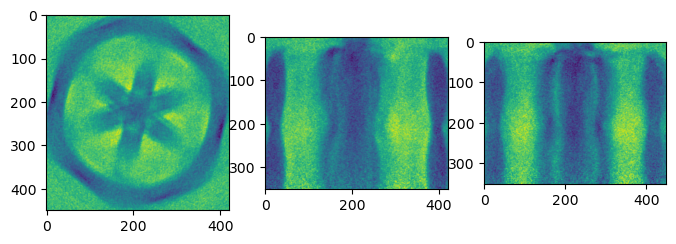

In [4]:
#Import data
recon_location = "reconstructions/foamRecon_NotNormalized_20240805-123810_SIRT_CUDA.tif"
tomo, tomo_scale_info = convert_to_numpy(recon_location)

#Volume dimensions
w,h,d = np.shape(tomo)
print(w,h,d)

fig1, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (8,8))

#Dimensions for cropped image (used later for electron density)
a, b = 30, 380
c, d = 90, -90
e, f = 105, -105
axs[0].imshow(tomo[tomo.shape[0]//2,c:d,e:f])
axs[1].imshow(tomo[a:b,tomo.shape[1]//2,e:f])
axs[2].imshow(tomo[a:b,c:d,tomo.shape[2]//2])

tomo = tomo[a:b, c:d, e:f]

# tomo = -tomo

# axs[0].imshow(tomo[tomo.shape[0]//2,:,:])
# axs[1].imshow(tomo[:,tomo.shape[1]//2,:])
# axs[2].imshow(tomo[:,:,tomo.shape[2]//3])

## Scale tomography reconstruction

In [5]:
#Read in Kevin projection for reference
aligned_proj_location = "alignedProjections/aligned_foamTomo20240718-165515.tif"
kevinProjections, kevin_proj_scale_info = convert_to_numpy(aligned_proj_location)
kevinProjOriginal = kevinProjections[0] #Every 72 projections

### Calculate scale information

In [6]:
ang = tomopy.angles(5, 0, 360) #First angle should theoretically be the same no matter how many angles I project through
tomopyProjOriginal = tomopy.project(tomo, ang) ## uncomment to first figure out the values for kevinProj_p5 and p95
tomopyProjOriginal = tomopyProjOriginal[0, 40:,110:-110]
# tomopyProjOriginal = tomopyProjOriginal[0]

(array([219]), array([215]))
(215, 219)
1.4692552533148031
0.026348934632749465


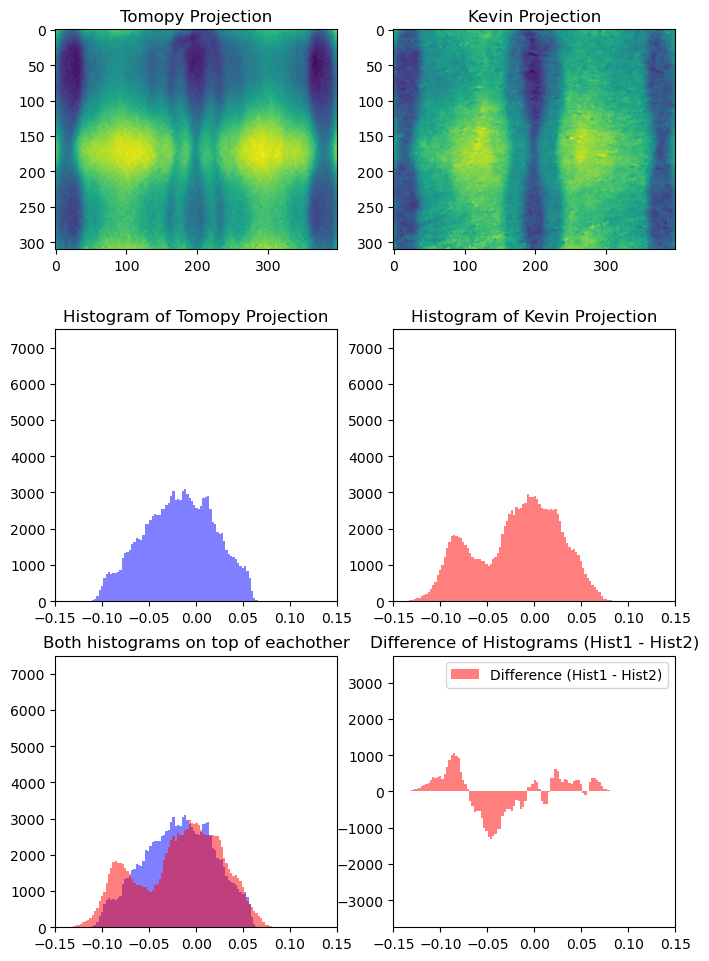

In [7]:
kevinProj, tomopyProj = cropAndAlign(kevinProjOriginal, tomopyProjOriginal)

# # Scale tomopyProj to match kevinProj using Least Squares Fit
flattened_array = tomopyProj.flatten()
flattened_column = flattened_array.reshape(-1,1)

A = np.hstack((np.ones((flattened_array.shape[0],1)), flattened_column))
B = kevinProj.flatten().reshape(-1,1)
X = np.linalg.lstsq(A,B, rcond=None)

shift = X[0][0][0]
scale = X[0][1][0]

print(scale)
print(shift)

tomopyProj = tomopyProj * scale + shift

# # Calculate the 1st and 99th percentiles of tomopyProj_cropped and kevinProj
# tomopyProj_cropped_p1, tomopyProj_cropped_p99 = np.percentile(tomopyProj, [1, 99])
# kevinProj_p1, kevinProj_p99 = np.percentile(kevinProj, [1, 99])
# print("kevinProj_p1: ", kevinProj_p1)
# print("kevinProj_p99: ", kevinProj_p99)
# # Normalize tomopyProj_cropped to [0, 1] based on its 5th and 95th percentiles
# tomopyProj = (tomopyProj - tomopyProj_cropped_p1) / (tomopyProj_cropped_p99 - tomopyProj_cropped_p1)
# # Scale to [kevinProj_p1, kevinProj_p99]
# tomopyProj = tomopyProj * (kevinProj_p99 - kevinProj_p1) + kevinProj_p1

showHistogramComparison(kevinProj, tomopyProj)

### Correct full Tomo

In [8]:
tomo_scaled = tomo.copy()

#Scale all parts of the reconstruction other than the part that is already listed as 
tomo_nonzero_indices = tomo != 0
tomo_scaled[tomo_nonzero_indices] = tomo[tomo_nonzero_indices] * scale + shift

ang = tomopy.angles(5, 0, 360) #First angle should theoretically be the same no matter how many angles I project through
tomopyProjOriginal_scaled = tomopy.project(tomo, ang)[0, 40:,110:-110]

(array([219]), array([215]))
(215, 219)


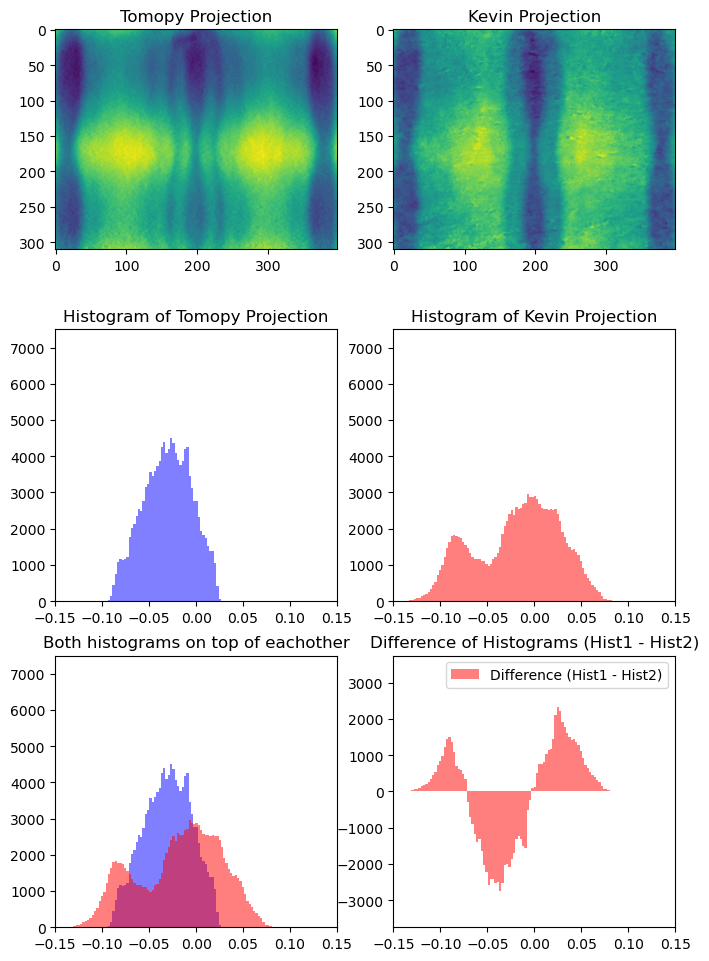

In [9]:
kevinProj, tomopyProj = cropAndAlign(kevinProjOriginal, tomopyProjOriginal_scaled)
# print(kevinProj)
# print(tomopyProj)
showHistogramComparison(kevinProj, tomopyProj)

## Electron and Mass density calculations

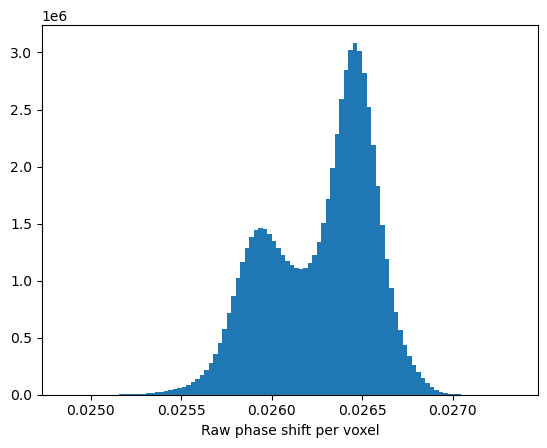

In [10]:
##Plot histogram of pixel volumes throughout whole cropped volume
# rough_volume = tomo_scaled[a:b, c:d, e:f]
rough_volume = tomo_scaled.copy()
plt.hist(np.ndarray.flatten(rough_volume), 100, log=False)
plt.xlabel('Raw phase shift per voxel')
plt.show()

64
0.02644766


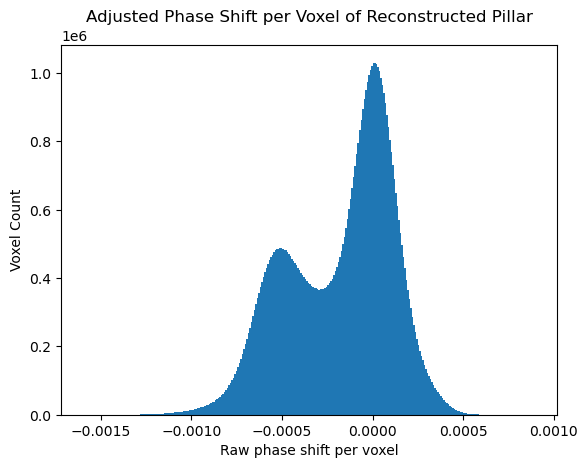

In [11]:
#Shift so phase difference of peak is 0
##TODO: Is this really supposed to move the phase difference peak to 0 or the phase difference absolute min to 0
from scipy.signal import find_peaks
count, division = np.histogram(np.ndarray.flatten(rough_volume), 100)

print(np.argmax(count, axis = None))
ind = np.argmax(count, axis = None)

# print(division[-1])
# # rough_volume = rough_volume - division[-1]
# rough_volume = rough_volume - np.percentile(division, 87)

print(division[ind])
rough_volume = rough_volume - division[ind]

plt.hist(np.ndarray.flatten(rough_volume), 300, log=False)
plt.title("Adjusted Phase Shift per Voxel of Reconstructed Pillar")
plt.xlabel('Raw phase shift per voxel')
plt.ylabel('Voxel Count')
plt.show()

Text(0.5, 1.0, 'Histogram of rough_volume_proj_check')

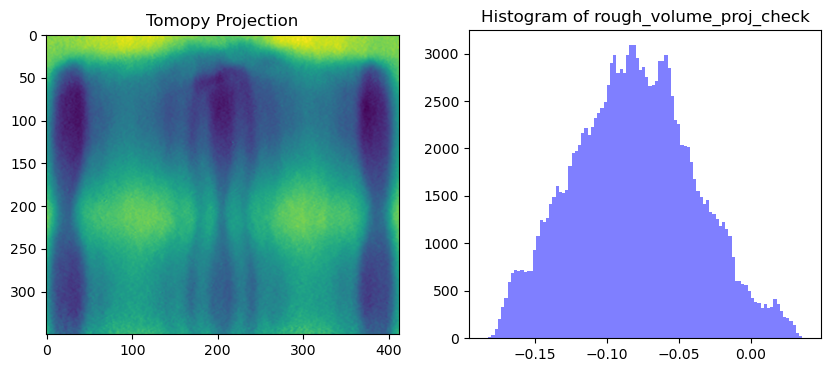

In [12]:
#Doublecheck projection through volume phase distribution
ang = tomopy.angles(5, 0, 360) #First angle should theoretically be the same no matter how many angles I project through
rough_volume_proj_check = tomopy.project(rough_volume, ang)[0]
rough_volume_proj_check = rough_volume_proj_check[:,103:515] #Remove zero padding on outside after projecting

#Plotting
fig1, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].imshow(rough_volume_proj_check)
axs[0].set_title('Tomopy Projection')
axs[1].hist(np.ndarray.flatten(rough_volume_proj_check), bins=100, alpha=0.5, color = 'blue')
axs[1].set_title('Histogram of rough_volume_proj_check')
# axs[1].set_ylim(0,20000)
# axs[1].set_xlim(-0.15,0.15)

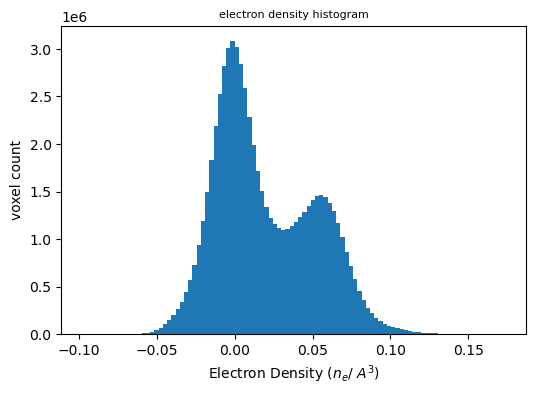

In [13]:
#Convert to electron density
import scipy.constants as constants
wavelength = 1239.8 / 8872 * 10**(-9)
lengthOfFullImageMicrons = 20.96*10**(-6) #In microns
lengthOfFullImagePixels = 900
voxel_depth = lengthOfFullImageMicrons/lengthOfFullImagePixels
r_0 = constants.physical_constants['classical electron radius'][0]

vol_proj_shift_edensity = - (rough_volume) / (wavelength * r_0) * (1/ voxel_depth) * (10**-10)**3

fig4, ax = plt.subplots(1, figsize=(6,4))
ax.hist(np.ndarray.flatten(vol_proj_shift_edensity), 100, log=False)
ax.set_title('electron density histogram', fontsize=8)
ax.set_xlabel('Electron Density ($n_e$/ $A^3$)')
ax.set_ylabel('voxel count')
plt.show()

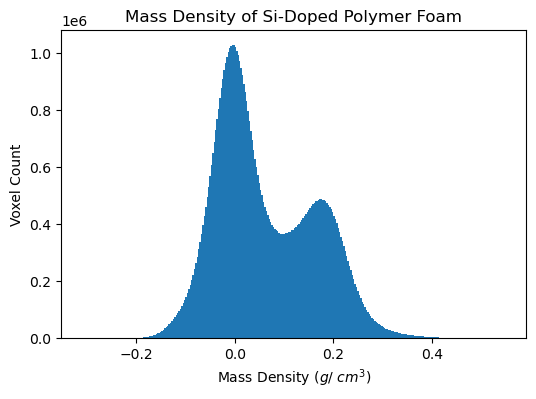

In [14]:
#Convert to mass density assuming composition (C48H72Si8028)
u = constants.physical_constants['atomic mass constant'][0]
A_bar = 1321.76 #This needs to change
Z_bar = 696 #This needs to change

#Convert to mass density
vol_proj_shift_mdensity = vol_proj_shift_edensity * u * (A_bar/ Z_bar)

#convert kg/A^3 to g/cm^3
vol_proj_shift_mdensity = vol_proj_shift_mdensity * 1000 * (10**8)**3

fig5, ax = plt.subplots(1, figsize=(6,4))
ax.hist(np.ndarray.flatten(vol_proj_shift_mdensity), 300, log=False)
ax.set_title('Mass Density of Si-Doped Polymer Foam', fontsize=12)
ax.set_xlabel('Mass Density ($g$/ $cm^3$)')
ax.set_ylabel('Voxel Count')
plt.show()

Local maxima bins (edges): [ 0.05522297 -0.0018106 ]
Local maxima bins (midpoints): [ 0.05567562 -0.00135795]


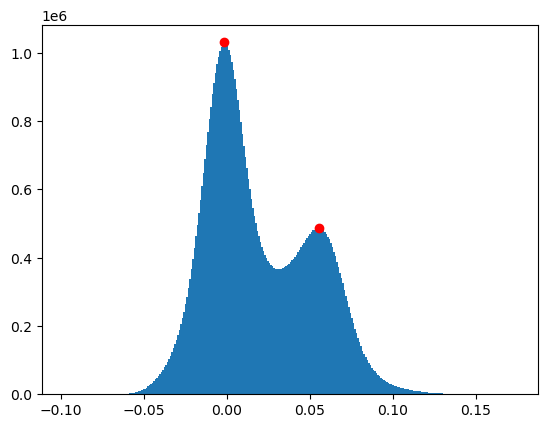

In [15]:
# Example data
# data = np.ndarray.flatten(vol_proj_shift_mdensity)
data = np.ndarray.flatten(vol_proj_shift_edensity)

# Create histogram and return counts and bin edges
counts, bin_edges = np.histogram(data, bins=300)

# Identify local maxima
local_maxima_indices = np.where((counts[1:-1] > counts[:-2]) & (counts[1:-1] > counts[2:]))[0] + 1

# If fewer than 2 local maxima, handle accordingly
if len(local_maxima_indices) < 2:
    print("Fewer than 2 local maxima found.")
    max_indices = local_maxima_indices
else:
    # Sort the local maxima by their count values and select the top two
    max_indices = local_maxima_indices[np.argsort(counts[local_maxima_indices])[-2:]]

# Retrieve the corresponding bin edges
max_bins = bin_edges[max_indices]

# Alternatively, you might want to return the midpoints of these bins
max_bin_midpoints = (bin_edges[max_indices] + bin_edges[max_indices + 1]) / 2

print("Local maxima bins (edges):", max_bins)
print("Local maxima bins (midpoints):", max_bin_midpoints)

# Plot the histogram and mark the local maxima
plt.hist(data, bins=300)
plt.plot(max_bin_midpoints, counts[max_indices], 'ro')  # Highlight the local maxima
plt.show()

In [24]:
0.175573-0.11712

0.058453000000000005